In [1]:
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 28
mpl.rcParams['axes.unicode_minus'] = False
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['xtick.color'] = 'black'
mpl.rcParams['ytick.color'] = 'black'
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.minor.visible'] = True
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.linewidth'] = 1

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.modeling import models, fitting
from astropy.table import Table
from astropy.visualization import ZScaleInterval, simple_norm, MinMaxInterval, SqrtStretch
from astropy.visualization import ImageNormalize
from astropy.stats import sigma_clipped_stats

In [3]:
from pypeit import spec2dobj, specobj
spec2DObj = spec2dobj.Spec2DObj.from_file('/home/lupengjun/OII_emitter/spectra/pypeit_output/magellan_ldss3/Science_coadd/spec2d_ccd0105c1-ccd0107c1-Targ1 spec.fits', detname='DET01')
spec1DObj = specobj.SpecObj.from_file(ifile='/home/lupengjun/OII_emitter/spectra/pypeit_output/magellan_ldss3/Science_coadd/spec1d_ccd0105c1-ccd0107c1-Targ1 spec.fits')
slitmask = spec2DObj.slits.slit_img(flexure=spec2DObj.sci_spat_flexure)
sciimg = spec2DObj.sciimg
skymodel = spec2DObj.skymodel
objmodel = spec2DObj.objmodel
ivarmodel = spec2DObj.ivarmodel
bpmmask = spec2DObj.bpmmask
waveimg = spec2DObj.waveimg
img_gpm = spec2DObj.select_flag(invert=True)
model_gpm = img_gpm.copy()

[INFO]    :: Loading SpecObj from /home/lupengjun/OII_emitter/spectra/pypeit_output/magellan_ldss3/Science_coadd/spec1d_ccd0105c1-ccd0107c1-Targ1 spec.fits


In [4]:
objmask = slitmask == 530
objsci = (sciimg - skymodel) * model_gpm.astype(float)
objsci = np.ma.array(objsci, mask=~objmask)
objwave = np.ma.array(waveimg, mask=~objmask)
objwave_mask_OII = (objwave>7100) & (objwave<7260)
objwave_mask_OIII = (objwave>9560) & (objwave<9720)
objwave_window_OII = np.ma.array(objwave, mask=~objwave_mask_OII)
objwave_window_OIII = np.ma.array(objwave, mask=~objwave_mask_OIII)
objsci_OII = np.ma.array(objsci, mask=~objwave_mask_OII)
objsci_OIII = np.ma.array(objsci, mask=~objwave_mask_OIII)

In [5]:
def plot_spec_2d_1d_fit(objsci, objwave, tb, wave_range, space_range, label='OII'):
    '''
    wave range in Angstrom, space range in pixel index
    '''
    if label=='OII': 
        label = '[OII] $\lambda\lambda3726,3729$'
        center_wave = (3726+3729)/2
    elif label=='OIII': 
        label = '[OIII] $\lambda5007$'
        center_wave = 5007
    else:
        label = label
        center_wave = np.mean(wave_range)
    #1d spectra
    wave = tb['OPT_WAVE'] #optimal or box?
    # wave = spec1DObj.OPT_WAVE
    flux = tb['OPT_FLAM']
    # flux = spec1DObj.OPT_FLAM
    errors = tb['OPT_FLAM_SIG']
    # errors = spec1DObj.OPT_FLAM_SIG
    mask = tb['OPT_MASK']
    # mask = spec1DObj.OPT_MASK
    wave_mask = (wave>wave_range[0]) & (wave<wave_range[1])
    wave_cut = wave[mask&wave_mask]
    flux_cut = flux[mask&wave_mask]
    errors_cut = errors[mask&wave_mask]
    #fitting emission line
    g_init = models.Gaussian1D(amplitude=1., mean=np.mean(wave_range), stddev=20)
    fit_g = fitting.LevMarLSQFitter(calc_uncertainties=True)
    g = fit_g(g_init, wave_cut, flux_cut, weights=1/errors_cut)
    #2d spectra
    wave_range_index = np.where((objwave<wave_range[1]) & (objwave>wave_range[0]))[0]
    wave_cut_index = [wave_range_index.min(), wave_range_index.max()]
    objsci_cutout = objsci.T[space_range[0]:space_range[1], wave_cut_index[0]:wave_cut_index[1]]
    #sigma clipping to determine the normalization
    mean, median, std = sigma_clipped_stats(objsci_cutout, sigma=2.0, maxiters=None)
    zscale_norm = ImageNormalize(vmin=median-2*std, vmax=median+3*std, interval=ZScaleInterval())
    #plotting
    fig, (ax0, ax1, ax2) = plt.subplots(3, 1, figsize=(12.5, 10), gridspec_kw={'height_ratios': [1, 3, 1]}, sharex=True)
    fig.subplots_adjust(hspace=0)
    ax0.imshow(objsci_cutout, norm=zscale_norm, cmap='gray_r', extent=[wave_range[0], wave_range[1], (space_range-np.mean(space_range))[0]*0.189, (space_range-np.mean(space_range))[1]*0.189])
    ax0.set_aspect('auto')
    ax0.set_ylabel('arcsec')
    # # xtick label color black but tick color white
    # ax0.tick_params(axis='x', colors='w', labelcolor='k', which='both')
    # ax0.tick_params(axis='y', colors='w', labelcolor='k', which='both')
    ax1.step(wave_cut, flux_cut, lw=1.5, label='Data', c='k')
    ax1.step(wave_cut, errors_cut, lw=1.5, label='Error', c='green')
    ax1.plot(wave_cut, g(wave_cut), lw=2, label='Model', c='r')
    ax1.set_xlim(wave_range[0], wave_range[1])
    ax1.set_ylim(-0.9, 2)
    ax1.set_ylabel('$F_\lambda~(10^{-17} \\rm{erg~s^{-1}~cm^{-2}~Å^{-1}})$')
    ax1.text(wave_range[0]+5, 1.6, label, color='red')
    ax1.text(wave_range[0]+5, 1.3, '$z=%.4f$'%(g.mean/center_wave-1), color='red')
    ax1.legend(fontsize=20)
    ax1.set_yticks(np.arange(-0.5, 2.5, 0.5))
    ax2.plot(wave_cut,  flux_cut-g(wave_cut), 'k.')
    ax2.axhline(0, color='red', linestyle='--', lw=1.5)
    ax2.set_xlim(wave_range[0], wave_range[1])
    ax2.set_ylim(-0.6, 0.6)
    ax2.set_xlabel('Observed Wavelength $\lambda$(Å)', fontsize=30)
    ax2.set_ylabel('Residuals')
    name = label.split(' ')[0]
    plt.savefig(f'{name}_spectra.png', bbox_inches='tight')
    plt.show()
    
    return g.amplitude, g.mean, g.stddev, np.diag(g.cov_matrix.cov_matrix)

In [6]:
tb = Table.read('/home/lupengjun/OII_emitter/spectra/pypeit_output/magellan_ldss3/Science_coadd/spec1d_ccd0105c1-ccd0107c1-Targ1 spec.fits', hdu=1)
tb

TRACE_SPAT,FWHMFIT,OPT_WAVE,OPT_FLAM,OPT_FLAM_SIG,OPT_FLAM_IVAR,OPT_COUNTS,OPT_COUNTS_IVAR,OPT_COUNTS_SIG,OPT_MASK,OPT_COUNTS_SKY,OPT_FRAC_USE,OPT_CHI2,BOX_NPIX,BOX_WAVE,BOX_FLAM,BOX_FLAM_SIG,BOX_FLAM_IVAR,BOX_COUNTS,BOX_COUNTS_IVAR,BOX_COUNTS_SIG,BOX_MASK,BOX_COUNTS_SKY,trace_spec
float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,int64
517.682,25.0,6666.120020839569,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,6666.120020839569,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0
517.682,25.0,6667.0242192849455,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,0.0,0.0,0.0,6667.039583056231,0.0,0.0,0.0,0.0,0.0,0.0,False,0.0,1
517.682,25.0,6668.2531698258745,-2.711883568336603,0.294370734848438,11.54013092467427,-375.6827664232808,0.0006013263967983145,40.77977879033657,True,168.79544227063235,0.5390583935283039,1.3263449170298096,8.75450793650792,6668.253362208863,-0.8494383879266151,0.146652625925485,46.496505316891515,-117.75148937170535,0.00241964282317709,20.329391005212372,True,42.66140068526216,2
517.682,25.0,6669.320683421867,-0.8076252471421806,0.27805714707750717,12.933970766034307,-112.15820665107736,0.0006706401276340896,38.61492823940627,True,9.212909763231586,0.47912504868536065,1.520478004296054,7.8730158730158735,6669.320756704474,-0.18843296950259839,0.13309789223264856,56.44918084607356,-26.18595044954871,0.002923039909492392,18.49620488465236,True,2.366502780398288,3
517.682,25.0,6670.3873658307075,-0.9897057851662167,0.28616990109878526,12.211024234818252,-137.783140316695,0.0006300458469791229,39.83950405108188,True,46.20906529187965,0.8147140672797565,1.51750889202513,15.0,6670.387648475912,-0.42297515254070644,0.19070989930335666,27.49498748401526,-58.925204683254705,0.001416710257017065,26.568037824613572,True,20.60301642508362,4
517.682,25.0,6671.307561406026,16.51557792726088,23.343101268194598,0.0018351978500016632,2304.125017913487,9.42884212014919e-08,3256.6479880159773,True,37.22759912832537,0.8682605389392117,0.002071879151398396,15.873015873015873,6671.287084911651,9.250331983567836,18.731619514117767,0.002850029431051846,1291.3700298421488,1.4623878742740855e-07,2614.98204539122,True,17.021288742107636,5
517.682,25.0,6672.7314843529875,-2.651764521049497,0.18957699821612103,27.82458626566535,-371.1645927323053,0.0014202524491353228,26.53488602617372,True,27.246543002223266,0.6695648786531642,2.184550053213028,11.873015873015873,6672.714068568047,-1.0997135327643606,0.11466953757359606,76.05081590810705,-154.0282149235887,0.003876702300202485,16.060859171366545,True,7.100154410022172,6
517.682,25.0,6674.023076092354,0.6344801880131038,1.1558574679770401,0.7484993600485386,89.07082732930225,3.798014268570688e-05,162.26382303578117,True,6.650166251660882,0.8683696217293565,0.0862229932872577,15.873015873015873,6674.006052893795,0.38970711722837637,0.8412512817046155,1.4130206938235312,54.74566024926565,7.160210683210041e-05,118.17812612714243,True,0.7028928259962219,7
517.682,25.0,6675.343846687263,-0.39630246655842627,1.5232066754580946,0.4310050227924575,-55.80286512950557,2.173816527597062e-05,214.4808671343944,True,-6.1502849203896,0.868347041612816,0.023420619022519504,15.873015873015873,6675.328828087184,-0.24657825498973351,1.195970517287433,0.6991317938404057,-34.74435571148997,3.5212760825930775e-05,168.51942226138047,True,-2.857949698675241,8


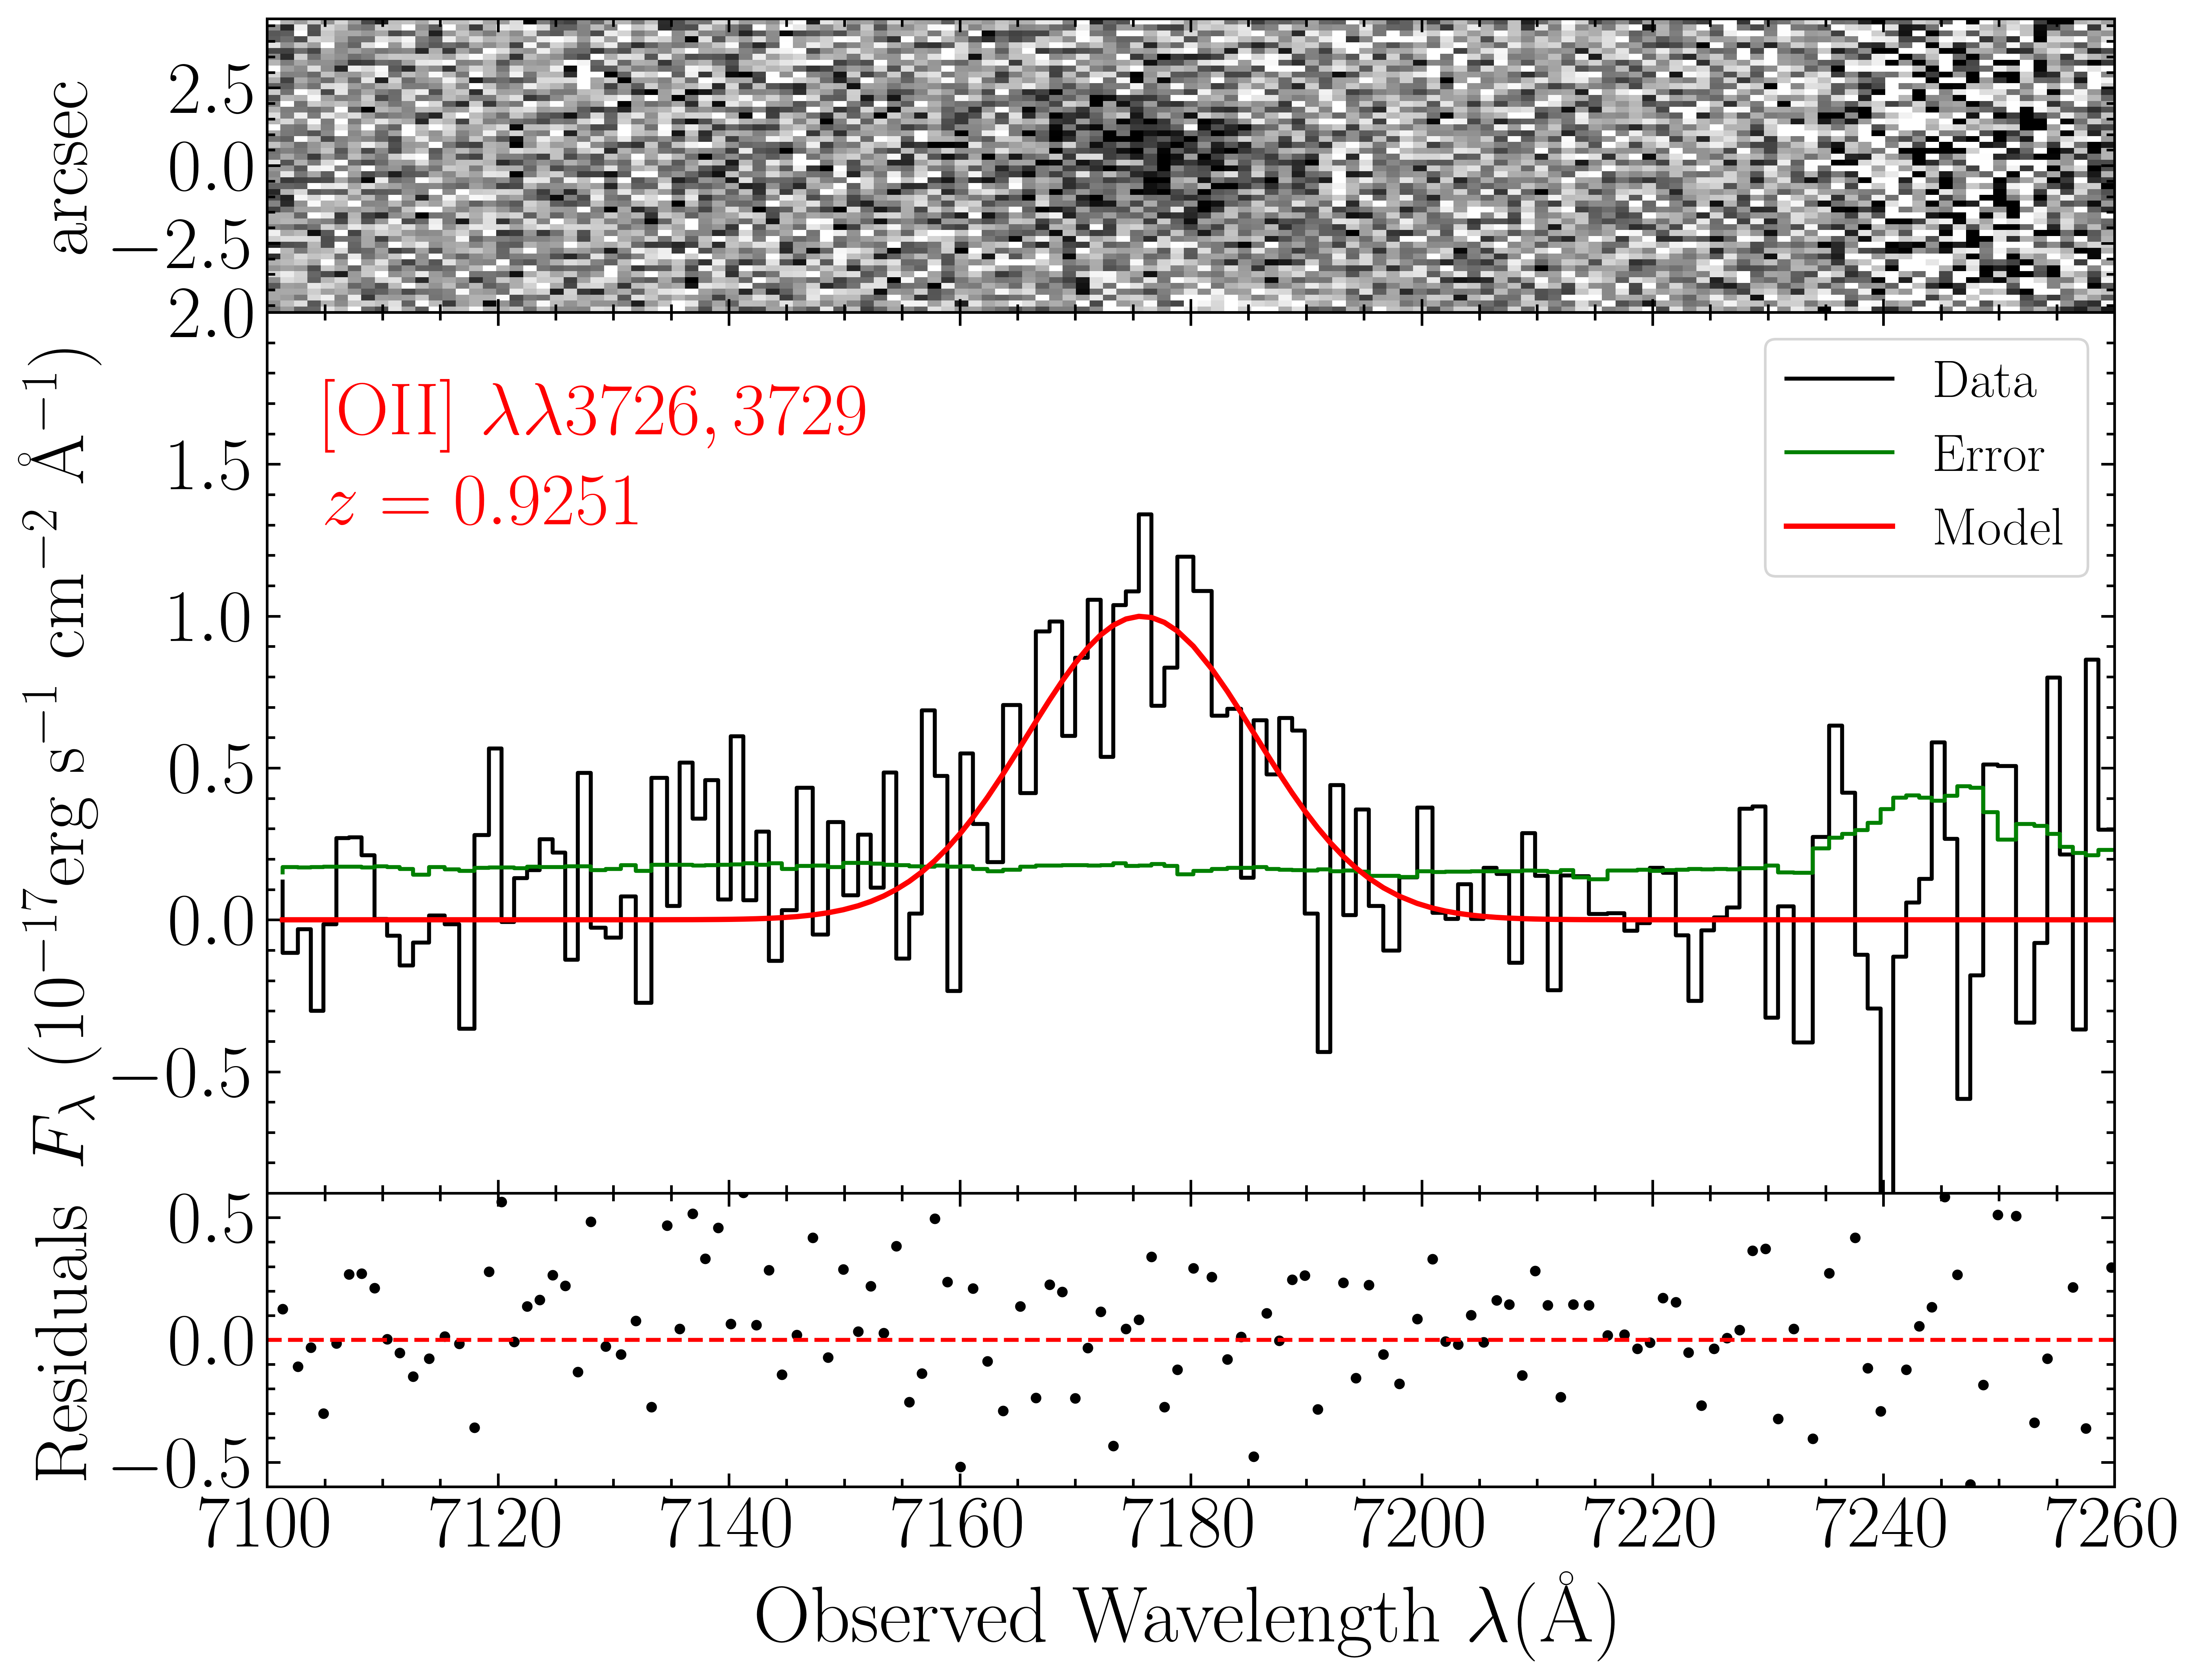

In [7]:
OII_wave_range = [7100, 7260]
OII_space_range = [490, 540]
OII_flux, OII_wave, OII_sig, OII_error = plot_spec_2d_1d_fit(objsci, objwave, tb, OII_wave_range, OII_space_range, label='OII')

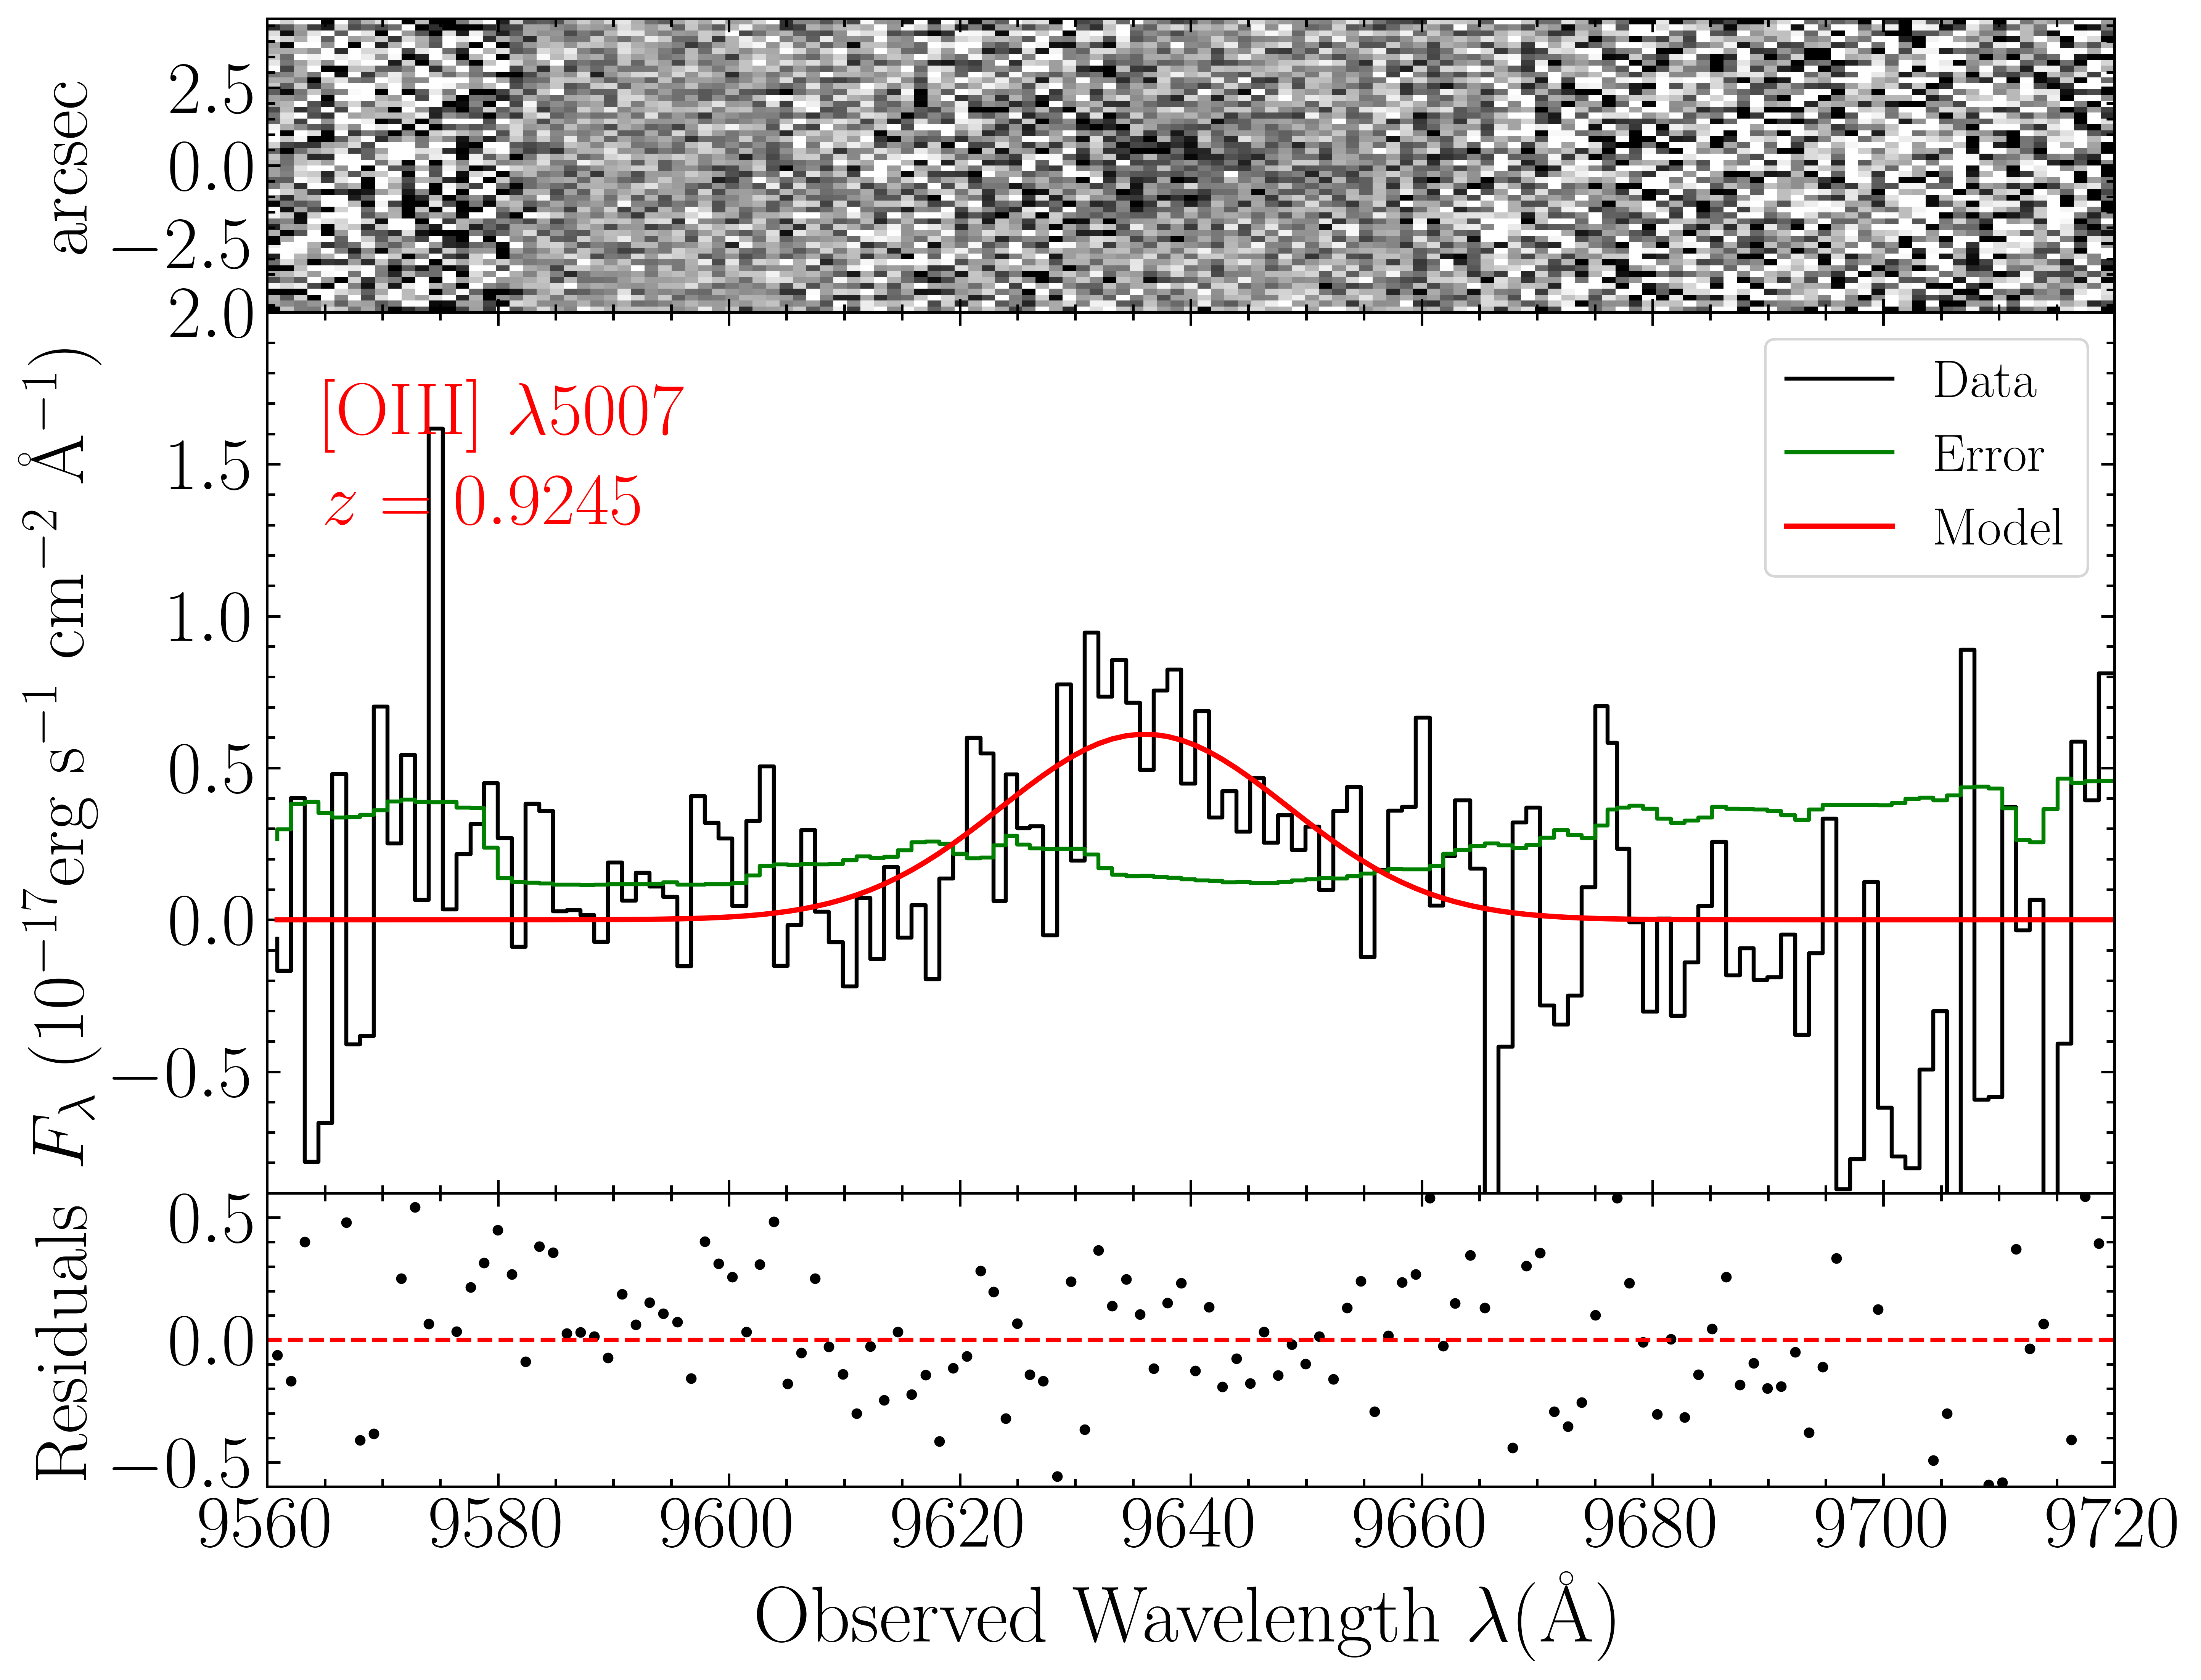

In [8]:
OIII_wave_range = [9560, 9720]
OIII_space_range = [490, 540]
OIII_flux, OIII_wave, OIII_sig, OIII_error =plot_spec_2d_1d_fit(objsci, objwave, tb, OIII_wave_range, OIII_space_range, label='OIII')